100%|██████████| 42/42 [00:00<?, ?it/s]


4544 142


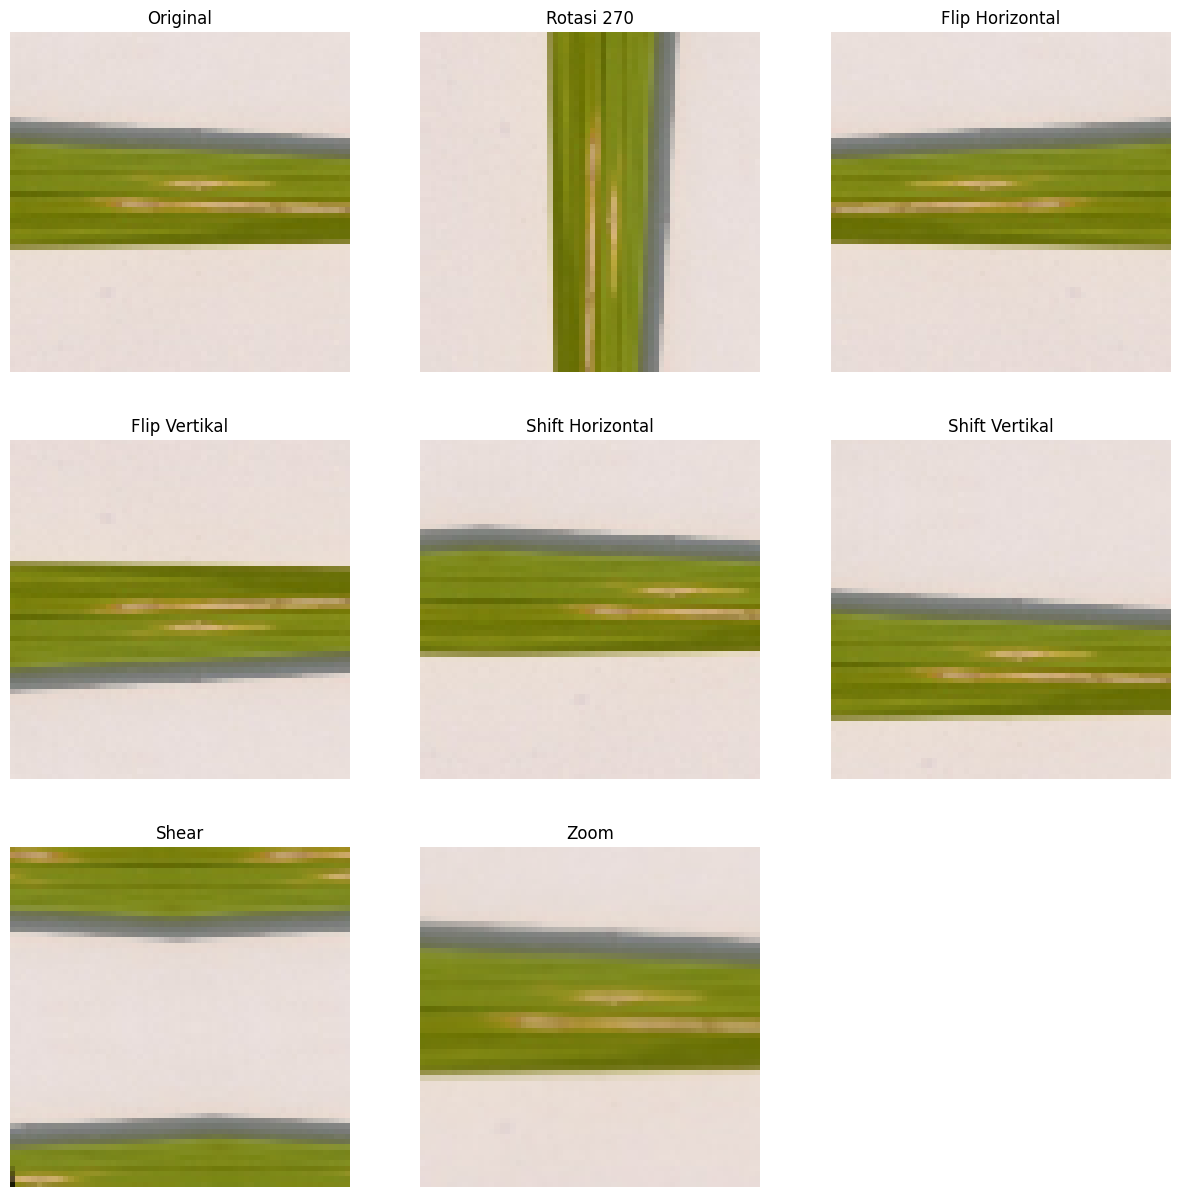

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm  # Untuk menampilkan bar progress
from sklearn.utils import shuffle

np.random.seed(50)

CATEGORIES = ['blight', 'blast', 'tungro', 'healthy']
IMG_SIZE = 64  # Ubah ukuran gambar target menjadi lebih besar

def augment_image(image):
    augmented_images = []

    # Tambahkan padding untuk menghindari garis hitam
    padding_color = [0, 0, 0]  # Warna hitam untuk padding (RGB)
    padded_image = cv2.copyMakeBorder(image, 40, 40, 40, 40, cv2.BORDER_REFLECT)

    # Rotasi 90, 180, 270 derajat
    for angle in [270]:
        M = cv2.getRotationMatrix2D((IMG_SIZE / 2 + 40, IMG_SIZE / 2 + 40), angle, 1)
        rotated = cv2.warpAffine(padded_image, M, (IMG_SIZE + 80, IMG_SIZE + 80))

        # Crop kembali ke ukuran asli tanpa garis hitam
        cropped_rotated = rotated[40:IMG_SIZE + 40, 40:IMG_SIZE + 40]
        augmented_images.append((cropped_rotated, f"Rotasi {angle}"))

    # Flip horizontal
    flipped_horizontal = cv2.flip(image, 1)
    augmented_images.append((flipped_horizontal, "Flip Horizontal"))

    # Flip vertical
    flipped_vertical = cv2.flip(image, 0)
    augmented_images.append((flipped_vertical, "Flip Vertikal"))

    # Width shift
    width_shift = int(IMG_SIZE * 0.2)
    M_shift_w = np.float32([[1, 0, width_shift], [0, 1, 0]])
    shifted_w = cv2.warpAffine(padded_image, M_shift_w, (IMG_SIZE + 80, IMG_SIZE + 80))
    cropped_shifted_w = shifted_w[40:IMG_SIZE + 40, 40:IMG_SIZE + 40]
    augmented_images.append((cropped_shifted_w, "Shift Horizontal"))

    # Height shift
    height_shift = int(IMG_SIZE * 0.2)
    M_shift_h = np.float32([[1, 0, 0], [0, 1, height_shift]])
    shifted_h = cv2.warpAffine(padded_image, M_shift_h, (IMG_SIZE + 80, IMG_SIZE + 80))
    cropped_shifted_h = shifted_h[40:IMG_SIZE + 40, 40:IMG_SIZE + 40]
    augmented_images.append((cropped_shifted_h, "Shift Vertikal"))

    # Shear
    shear = 0.2
    M_shear = np.float32([[1, shear, -shear * IMG_SIZE // 2], [0, 1, 0]])
    sheared = cv2.warpAffine(padded_image, M_shear, (IMG_SIZE + int(shear * IMG_SIZE), IMG_SIZE + int(shear * IMG_SIZE)))
    center_crop = sheared[int(shear * IMG_SIZE // 2):int(shear * IMG_SIZE // 2) + IMG_SIZE, int(shear * IMG_SIZE // 2):int(shear * IMG_SIZE // 2) + IMG_SIZE]
    augmented_images.append((center_crop, "Shear"))

    # Zoom
    zoom_factor = 0.2
    zoomed = cv2.resize(image, None, fx=1 + zoom_factor, fy=1 + zoom_factor, interpolation=cv2.INTER_LINEAR)
    start = int(zoom_factor * IMG_SIZE // 2)
    center_crop = zoomed[start:start + IMG_SIZE, start:start + IMG_SIZE]
    augmented_images.append((center_crop, "Zoom"))

    return augmented_images

def get_data(DATADIR, raw_data, augment=False):
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)  # Path ke sub-direktori kategori
        if not os.path.exists(path):
            print(f"Path not found: {path}")
            continue
        class_num = CATEGORIES.index(category)

        for img in sorted(tqdm(os.listdir(path))):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                if img_array is None:
                    print(f"Failed to read image: {os.path.join(path, img)}")
                    continue

                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
                raw_data.append([new_array, class_num, "Original"])

                if augment:
                    augmented_arrays = augment_image(new_array)
                    for aug, aug_name in augmented_arrays:
                        raw_data.append([aug, class_num, aug_name])  # Tambahkan gambar augmentasi

            except Exception as e:
                print(f"Error processing image {os.path.join(path, img)}: {e}")

raw_training_data = []
raw_testing_data = []

get_data("SplitData/Training", raw_training_data, augment=True)
get_data("SplitData/Testing", raw_testing_data, augment=False)

print(len(raw_training_data), len(raw_testing_data))

# Menampilkan satu gambar asli dan beberapa gambar augmentasi dari raw_training_data
if raw_training_data:
    img, label, name = raw_training_data[0]

    augmented_images = augment_image(img)

    num_augments = len(augmented_images) + 1
    grid_size = int(np.ceil(np.sqrt(num_augments)))

    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))

    axs[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title("Original")

    for i, (aug_img, aug_name) in enumerate(augmented_images):
        row = (i + 1) // grid_size
        col = (i + 1) % grid_size
        axs[row, col].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        axs[row, col].set_title(aug_name)

    for i in range(num_augments, grid_size * grid_size):
        fig.delaxes(axs.flatten()[i])

    for ax in axs.flat:
        ax.axis('off')

    plt.show()
else:
    print("No training data found")

In [2]:
from sklearn.utils import shuffle
from typing import Tuple

X_TRAIN = []
Y_TRAIN = []

X_TEST = []
Y_TEST = []

# X_VAL = []
# Y_VAL = []


for features,label, _ in raw_training_data:
    X_TRAIN.append(features)
    Y_TRAIN.append(label)


for features,label, _ in raw_testing_data:
    X_TEST.append(features)
    Y_TEST.append(label)

X_TRAIN = np.array(X_TRAIN).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X_TEST = np.array(X_TEST).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_TRAIN = np.array(Y_TRAIN)
Y_TEST = np.array(Y_TEST)
X_TRAIN, Y_TRAIN = shuffle(X_TRAIN, Y_TRAIN)

X_TRAIN = X_TRAIN.astype(float) / 255.
X_TEST = X_TEST.astype(float) / 255.


# # Membagi data dengan proporsi 80% untuk training dan 20% untuk validasi
# split_index = int(0.8 * len(X_TRAIN))
# X_TRAIN, X_VAL = X_TRAIN[:split_index], X_TRAIN[split_index:]
# Y_TRAIN, Y_VAL = Y_TRAIN[:split_index], Y_TRAIN[split_index:]

# Menyimpan data jika diperlukan
# np.save('xtest.npy', X_TEST)
# np.save('ytest.npy', Y_TEST)

# Memeriksa bentuk data untuk memastikan semuanya sesuai
print("Shape of X_TRAIN:", X_TRAIN.shape)
print("Shape of Y_TRAIN:", Y_TRAIN.shape)
print("Shape of X_TEST:", X_TEST.shape)
print("Shape of Y_TEST:", Y_TEST.shape)
# print("Shape of X_VAL:", X_VAL.shape)
# print("Shape of Y_VAL:", Y_VAL.shape)

# Memastikan bahwa X_TRAIN dan Y_TRAIN tidak kosong
if X_TRAIN.shape[0] == 0 or Y_TRAIN.shape[0] == 0:
    raise ValueError("X_TRAIN dan Y_TRAIN tidak boleh kosong.")

Shape of X_TRAIN: (4544, 64, 64, 3)
Shape of Y_TRAIN: (4544,)
Shape of X_TEST: (142, 64, 64, 3)
Shape of Y_TEST: (142,)


In [ ]:
class conv_layer():

    # Sebagai inisialisasi layer convolusi
    def __init__(self, total_filters, filter_shape, lr, padding = 'no_padding', stride = 1, beta1 = 0.9, beta2 = 0.999):
        self.filters_ws = np.random.randn(*filter_shape, total_filters) * 0.1
        self.filter_bs = np.random.randn(total_filters) * 0.1
        self.padding = padding
        self.stride = stride
        self.din_dw = None
        self.din_db = None
        self.input = None
        self.mo = 0
        self.acc = 0
        self.mo_b = 0
        self.acc_b = 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.lr = lr

    def forward(self, input, training):
        #print(self.filters_ws)
        self.input = np.array(input, copy=True) # Input disimpan untuk digunakan nanti pada backward pass.


        ############### getting output dimentions here ###############

        # Dapatkan Dimensi Input dan Bobot:
        n, input_dim_h, input_dim_w, _ = input.shape # batch size, height, width, channel
        filter_dim_h, filter_dim_w, _, filter_dim_n = self.filters_ws.shape # height, width, channel, number of filters
        # contoh: self.filters_ws.shape adalah (3, 3, 3, 64) = (filter memiliki tinggi 3piksel, lebar 3piksel, 3 channel, 64 filter)
        # channel ditulis _ karena ada tapi tidak dipakai pada tahap ini. Tidak dipakai karena untuk menghitung ukuran output konvolusi pada saat proses padding atau tidak

        # Hitung Dimensi Output dan Padding:
        # Jika padding pd inputan convolusi
        # tujuan utamanya adalah mempertahankan dimensi tinggi dan lebar gambar input tetap sama setelah operasi konvolusi.
        if self.padding == 'keep_img_dim':
            output_shape = n, input_dim_h, input_dim_w, filter_dim_n
            filter_dim_h, filter_dim_w, _, _ = self.filters_ws.shape
            p_value = (filter_dim_h - 1) // 2, (filter_dim_w - 1) // 2
        # Jika padding pada inputan convolusi 'no_padding', dimensi output dihitung berdasarkan stride dan ukuran filter:
        elif self.padding == 'no_padding':
            out_dim_h = (input_dim_h - filter_dim_h) // self.stride + 1
            out_dim_w = (input_dim_w - filter_dim_w) // self.stride + 1
            output_shape = n, out_dim_h, out_dim_w, filter_dim_n
            p_value = 0, 0 # (0 tinggi, 0 lebar) karena tidak ada proses penambahan padding
        ############### got output dimentions ###############

        out_dim_n, out_dim_h, out_dim_w, out_dim_c = output_shape

        input_padded = self.pad(input, p_value) # Berisi input yang telah dipadding atau tidak
        output = np.zeros(output_shape) # Digunakan untuk menyimpan hasil operasi konvolusi

        # Proses pergerakan kernel/filter
        for i in range(out_dim_h): # vertikal (tinggi)
            for j in range(out_dim_w): # horizontal (lebar)
                start_pix_x = i * self.stride # sumbu-x (vertikal)
                end_pix_x = start_pix_x + filter_dim_h
                start_pix_y = j * self.stride # sumbu-y (horizontal)
                end_pix_y = start_pix_y + filter_dim_w

                output[:, i, j, :] = np.sum(
                    input_padded[:, start_pix_x:end_pix_x, start_pix_y:end_pix_y, :, np.newaxis] *
                    self.filters_ws[np.newaxis, :, :, :],
                    axis=(1, 2, 3)
                ) # Perkalian antara input dan bobot

        #print(output)
        return output + self.filter_bs

    def backward(self, input , grad):
        # Mendapatkan dimensi dari gradien output
        out_dim_n, out_dim_h, out_dim_w, out_dim_c = grad.shape

        # Mendapatkan dimensi dari input asli
        n, input_dim_h, input_dim_w, input_dim_c = self.input.shape

        # Mendapatkan dimensi dari filter
        filter_dim_h, filter_dim_w, _, _ = self.filters_ws.shape

        # Menentukan padding berdasarkan metode yang digunakan selama forward pass
        ############### getting p value here ###############
        if self.padding == 'keep_img_dim':
            p_value = (filter_dim_h - 1) // 2, (filter_dim_w - 1) // 2
        elif self.padding == 'no_padding':
            p_value = 0, 0
        ############### got p value  ###############


        # Input dengan padding atau tidak tergantung kondisi
        input_padded = self.pad(self.input, p_value)

        # Inisialisasi output untuk backward pass
        output = np.zeros_like(input_padded)
        #print(grad)

        # Menghitung gradien dari bias
        self.din_db = grad.sum(axis=(0, 1, 2)) / n # digunakan untuk menjumlahkan gradien di sepanjang dimensi batch, tinggi, dan lebar. kita mendapatkan rata-rata gradien untuk setiap filter (channel), yang selanjutnya dibagi dengan n (jumlah sampel dalam batch) untuk mendapatkan rata-rata gradien bias.

        # Inisialisasi gradien dari bobot filter
        self.din_dw = np.zeros_like(self.filters_ws)

        # Loop untuk menghitung gradien dari input dan bobot filter
        for i in range(out_dim_h):
            for j in range(out_dim_w):
                start_pix_x = i * self.stride
                end_pix_x = start_pix_x + filter_dim_h
                start_pix_y = j * self.stride
                end_pix_y = start_pix_y + filter_dim_w
                output[:, start_pix_x:end_pix_x, start_pix_y:end_pix_y, :] += np.sum(
                    self.filters_ws[np.newaxis, :, :, :, :] *
                    grad[:, i:i+1, j:j+1, np.newaxis, :],
                    axis=4
                ) # Gradien loss terhadap bobot
                self.din_dw += np.sum( # Rumus Gradien Loss terhadap bobot, dimana nilai input dikalikan dengan gradien loss
                    input_padded[:, start_pix_x:end_pix_x, start_pix_y:end_pix_y, :, np.newaxis] *
                    grad[:, i:i+1, j:j+1, np.newaxis, :],
                    axis=0
                ) # Gradien loss dikalikan dengan input

        # Normalisasi gradien bobot filter
        self.din_dw /= n # n itu jumlah batch

        #print(self.din_dw)

        # Pembaruan bobot filter menggunakan Adam optimizer
        ###################### Adam ###############################
        self.mo = self.beta1*self.mo + (1-self.beta1)*(self.din_dw)
        self.acc = self.beta2*self.acc + (1-self.beta2)*((self.din_dw) *(self.din_dw))
        self.filters_ws += -self.lr * self.mo / (np.sqrt(self.acc) + 1e-7)

        # Pembaruan bias menggunakan Adam optimizer
        self.mo_b = self.beta1*self.mo_b + (1-self.beta1)*(self.din_db)
        self.acc_b = self.beta2*self.acc_b + (1-self.beta2)*((self.din_db) *(self.din_db))
        self.filter_bs += -self.lr * self.mo_b / (np.sqrt(self.acc_b) + 1e-7)
        ###################### Adam ###############################

        # Mengembalikan gradien dari input setelah memotong padding
        return output[:, p_value[0]:p_value[0]+input_dim_h, p_value[1]:p_value[1]+input_dim_w, :]


    @staticmethod
    def pad(array, pad):
        return np.pad(
            array=array, # Array input yang akan di-pad.
            pad_width=((0, 0), (pad[0], pad[0]), (pad[1], pad[1]), (0, 0)),
            mode='constant'
        )

In [4]:
class pool_layer():

    def __init__(self, input_dim, stride = 2):
        self.pool_dim = input_dim # Menyimpan dimensi pooling sebagai atribut kelas.
        self.stride = stride # Menyimpan nilai stride sebagai atribut kelas.
        self.input = None # Inisialisasi variabel untuk menyimpan input selama forward pass.
        self.max_pixels = {} # Inisialisasi dictionary untuk menyimpan lokasi nilai maksimum selama forward pass untuk digunakan dalam backward pass.

    def forward(self, input, training):
        #print(input.shape)
        self.input = np.array(input, copy=True) # Menyimpan salinan dari input untuk digunakan dalam backward pass.
        n, input_dim_h, input_dim_w, c = input.shape # Mendapatkan bentuk dari input (batch size, height, width, channels).
        pool_x_dim, pool_y_dim = self.pool_dim # Mendapatkan dimensi pooling (tinggi dan lebar).
        out_dim_h = 1 + (input_dim_h - pool_x_dim) // self.stride # Menghitung dimensi tinggi output setelah pooling.
        out_dim_w = 1 + (input_dim_w - pool_y_dim) // self.stride # Menghitung dimensi lebar output setelah pooling.
        output = np.zeros((n, out_dim_h, out_dim_w, c)) # Menginisialisasi output dengan nol.

        for i in range(out_dim_h):
            for j in range(out_dim_w):
                start_pix_x = i * self.stride # Menentukan koordinat awal pada sumbu x untuk area pooling.
                end_pix_x = start_pix_x + pool_x_dim # Menentukan koordinat akhir pada sumbu x untuk area pooling.
                start_pix_y = j * self.stride # Menentukan koordinat awal pada sumbu y untuk area pooling.
                end_pix_y = start_pix_y + pool_y_dim # Menentukan koordinat akhir pada sumbu y untuk area pooling.
                focus_area = input[:, start_pix_x:end_pix_x, start_pix_y:end_pix_y, :] # Mengambil area fokus untuk pooling.
                self.store_max_pixels(focus_area, (i, j)) # Menyimpan lokasi nilai maksimum dari area fokus.
                output[:, i, j, :] = np.max(focus_area, axis=(1, 2)) # mengekstrak nilai maksimum dari setiap area pooling

        #print(output)
        return output

    def backward(self, input,grad):
        #print(grad)
        output = np.zeros_like(self.input) # Menginisialisasi output gradien dengan bentuk yang sama seperti input asli.
        n, out_dim_h, out_dim_w, c = grad.shape # Mendapatkan bentuk dari gradien output (batch size, height, width, channels).
        pool_x_dim, pool_y_dim = self.pool_dim # Mendapatkan dimensi pooling (tinggi dan lebar).
        for i in range(out_dim_h):
            for j in range(out_dim_w):
                start_pix_x = i * self.stride # Menentukan koordinat awal pada sumbu x untuk area pooling.
                end_pix_x = start_pix_x + pool_x_dim
                start_pix_y = j * self.stride
                end_pix_y = start_pix_y + pool_y_dim

                # Menambahkan gradien ke lokasi nilai maksimum yang sesuai.
                # menggunakan informasi tentang lokasi piksel maksimum (self.max_pixels) yang disimpan selama forward pass untuk menyebarkan gradien kembali ke lokasi piksel maksimum tersebut
                output[:, start_pix_x:end_pix_x, start_pix_y:end_pix_y, :] += grad[:, i:i + 1, j:j + 1, :] * self.max_pixels[(i, j)]
        #print(output)
        return output

    def store_max_pixels(self, area_pixels, i_j_location):
        mark_max = np.zeros_like(area_pixels) # Menginisialisasi array nol dengan bentuk yang sama seperti area pixels.
        n, h, w, c = area_pixels.shape # Mendapatkan bentuk dari area pixels.
        area_pixels = area_pixels.reshape(n, h * w, c) # Mereset area pixels ke dalam bentuk yang mudah untuk menemukan nilai maksimum.
        max_locations = np.argmax(area_pixels, axis=1) # Menemukan lokasi nilai maksimum dalam area pooling.
        n_idx, c_idx = np.indices((n, c)) # Membuat indeks untuk batch dan kanal.
        mark_max.reshape(n, h * w, c)[n_idx, max_locations, c_idx] = 1 # Menandai lokasi nilai maksimum.
        self.max_pixels[i_j_location] = mark_max # Menyimpan tanda lokasi maksimum dalam dictionary.

In [5]:
class reshape_layer():

    def __init__(self):
        self.input_shape = () # Inisialisasi variabel instance input_shape sebagai tuple kosong. Variabel ini akan digunakan untuk menyimpan bentuk (shape) dari input yang diterima oleh layer ini.

    def forward(self, input, training):
        self.input_shape = input.shape # Menyimpan bentuk (shape) dari input ke dalam self.input_shape.
        return np.ravel(input).reshape(input.shape[0], -1)
        # Menggunakan np.ravel(input) untuk mengubah input menjadi array 1D (flattening).
        # Menggunakan .reshape(input.shape[0], -1) untuk mengubah array 1D tersebut kembali menjadi 2D dengan jumlah baris sama dengan jumlah input awal (input.shape[0]) dan jumlah kolom sebanyak yang diperlukan untuk mempertahankan jumlah elemen total.

    def backward(self,input , grad):
        return grad.reshape(self.input_shape) # Menggunakan grad.reshape(self.input_shape) untuk mengembalikan gradien ke bentuk asli dari input yang disimpan di self.input_shape.

In [6]:
# all_ws = []
class weights_layer():
    def __init__(self, fan_in, fan_out, lr, beta1 = 0.9, beta2 = 0.999 , lamdaa = 0.0001):
        self.lamdaa = lamdaa
        self.lr = lr
        self.ws = np.random.randn(fan_in, fan_out)/np.sqrt(fan_in)
        self.bs = np.zeros(fan_out) #  Inisialisasi bias awal dengan nol

        # Inisialisasi momen dan akumulator untuk optimasi Adam.
        self.mo = 0
        self.acc = 0
        self.mo_b = 0
        self.acc_b = 0

        # Inisialisasi parameter beta1 dan beta2 untuk optimasi Adam.
        self.beta1 = beta1
        self.beta2 = beta2

    def forward(self,input, training):
        #all_ws.append(self.ws)
        #print(input.shape)
        #print(np.dot(input,self.ws) + self.bs)
        return np.dot(input,self.ws) + self.bs # Rumus Forward Propagation/Fully Connected Layer, Menghitung output dengan mengalikan input dengan bobot (self.ws) dan menambahkan bias (self.bs).

    # Pembaruan bobot dan bias menggunakan optimasi ADAM
    def backward(self,input,grad_output):
        dout_din = np.dot(grad_output, self.ws.T) # Inisialisasi gradien input
        dout_dws = np.dot(input.T, grad_output) # Inisialisasi gradien output
        dout_dbs = grad_output.mean(axis=0)*input.shape[0] # Inisialisasi gradien bias

        assert dout_dws.shape == self.ws.shape and dout_dbs.shape == self.bs.shape # Memastikan bentuk gradien bobot dan bias sama dengan bentuk bobot dan bias asli.
        #print(dout_dws)
        ###################### Adam ###############################
        # Pembaruan untuk bobot
        self.mo = self.beta1*self.mo + (1-self.beta1)*(dout_dws)
        self.acc = self.beta2*self.acc + (1-self.beta2)*((dout_dws) *(dout_dws))
        self.ws += -self.lr * self.mo / (np.sqrt(self.acc) + 1e-7) # Kejadian pembaruan bobot

        # Pembaruan untuk bias
        self.mo_b = self.beta1*self.mo_b + (1-self.beta1)*(dout_dbs)
        self.acc_b = self.beta2*self.acc_b + (1-self.beta2)*((dout_dbs) *(dout_dbs))
        self.bs += -self.lr * self.mo_b / (np.sqrt(self.acc_b) + 1e-7) # Kejadian pembaruan bias
        ###################### Adam ###############################
        """
        self.ws = self.ws - self.lr * dout_dws  #+ (self.lamdaa * np.sum(self.ws))/input.shape[0]
        self.bs = self.bs - self.lr * dout_dbs  #+ (self.lamdaa * np.sum(self.bs))/input.shape[0]
        """
        #print(dout_din)
        return dout_din # Mengembalikan gradien input (dout_din) yang akan diteruskan ke lapisan sebelumnya dalam jaringan.

In [7]:
class ReLU():
    def __init__(self):
        pass

    def forward(self, input, training):
        relu_forward = np.maximum(0,input) # setiap elemen input yang kurang dari 0 diubah menjadi 0.
        return relu_forward

    def backward(self, input, grad_output):
        relu_grad = input > 0 # Jika input lebih besar dari 0, gradien (turunan) adalah 1, dan jika kurang dari atau sama dengan 0, gradien adalah 0.
        return grad_output*relu_grad

# gak dipake
class tanh():
    def __init__(self):
        pass
    def forward(self, input, training): # Metode untuk propagasi maju. Menghitung nilai tangen hiperbolik dari input menggunakan np.tanh(input).
        return np.tanh(input)

    def backward(self, input, grad_output):
      return grad_output*(1-np.tanh(input)**2) # Metode untuk propagasi mundur. Menghitung gradien dari fungsi tangen hiperbolik terhadap input. Gradien ini adalah 1−tanh^2(input)

# gak dipake
class sigmoid():
    def __init__(self):
        pass
    def forward(self, input, training): # Menghitung nilai sigmoid dari input menggunakan 1 / (1 + np.exp(-1 * input)).
        return 1/(1+np.exp(-1* input))
    def backward(self, input, grad_output):
        return grad_output * (input*(1-input)) # Menghitung gradien dari fungsi sigmoid terhadap input. Gradien ini adalah sigmoid(input) x (1-sigmoid(input))


In [8]:
# Negative Log-Likelihood
def NLL(expected_probabilities,actual_labels):


    correct_prob = expected_probabilities[np.arange(len(expected_probabilities)),actual_labels] # berisi probabilitas yang diprediksi oleh model dan label sebenarnya

    p = np.exp(correct_prob) / np.sum(np.exp(expected_probabilities),axis=-1) # Implementasi softmax

    loss = -1 * np.log(p) # NLL

    return loss

def back_NLL(expected_probabilities,actual_labels):

    # (hotmap) representasi one-hot encoding dari label yang benar. Ini digunakan untuk membandingkan dengan probabilitas yang dihasilkan oleh model.
    hotmap = np.zeros_like(expected_probabilities)

    # Menghasilkan probabilitas aktual
    hotmap[np.arange(len(expected_probabilities)),actual_labels] = 1 # Membuat matriks dengan ukuran yang sama dengan expected_probabilities, di mana setiap baris hanya memiliki nilai 1 pada kolom yang sesuai dengan label aktual

    ratios = np.exp(expected_probabilities) / np.exp(expected_probabilities).sum(axis=-1,keepdims=True) # Implementasi softmax

    #print((- hotmap + ratios) / expected_probabilities.shape[0])
    # - hotmap + ratios, merupakan loss grad NLL. Misal loss_grad = - hotmap + ratios
    # Jadi average_grad = loss_grad / expected_probabilities.shape[0]. Dalam hal ini, normalisasi dilakukan dengan membagi gradien dengan ukuran batch. Ini memastikan bahwa gradien diperoleh secara rata-rata untuk seluruh batch, membuat pembaruan parameter lebih stabil dan konsisten selama pelatihan.
    return (- hotmap + ratios) / expected_probabilities.shape[0] # menghitung selisih antara probabilitas yang diprediksi untuk kelas yang benar dan probabilitas aktual dari model. Menggambarkan seberapa baik atau buruk model dalam memprediksi probabilitas untuk kelas yang benar dibandigkan dengan dibandingkan dengan probabilitas aktual. Misal Probabilitas model [0.7, 0.2, 0.1] untuk kelas A, B, dan C. Probabilitas Aktual [1, 0, 0],  100% untuk kelas A dan 0% untuk kelas lainnya.
    # expected_probabilities.shape[0] Ini memberikan ukuran batch yang diperlukan untuk normalisasi gradien dan memastikan bahwa gradien diperoleh dengan benar berdasarkan jumlah sampel dalam batch.
    # expected_probabilities adalah array dengan dimensi (batch_size, num_classes)

In [9]:
def run_batch(CNN, X, training):
    all_layers_outputs = []  # Membuat list kosong untuk menyimpan output dari setiap layer
    received = X  # Menerima input awal yaitu X (input batch)
    for layer in CNN:
        all_layers_outputs.append(layer.forward(received, training))  # Menjalankan forward pass untuk setiap layer
        received = all_layers_outputs[-1]  # Menyimpan output terakhir sebagai input untuk layer berikutnya

    assert len(all_layers_outputs) == len(CNN)  # Memastikan jumlah output yang dihasilkan sesuai dengan jumlah layer

    return all_layers_outputs  # Mengembalikan semua output dari setiap layer

def predict(CNN, X, Y, training):
    expected_probabilities = run_batch(CNN, X, training)[-1]  # Mendapatkan output akhir dari CNN setelah forward pass
    losses = NLL(expected_probabilities, Y)  # Menghitung Loss menggunakan fungsi Negative Log-Likelihood
    return (expected_probabilities.argmax(axis=-1), np.mean(losses))  # Mengembalikan prediksi kelas dan rata-rata loss

def train(CNN, X, actual_labels, training):
    layers_outputs = run_batch(CNN, X, training)  # Menjalankan batch input melalui CNN untuk mendapatkan output dari setiap layer
    layers_inputs = [X] + layers_outputs  # Menggabungkan input X dengan output dari setiap layer untuk digunakan dalam perhitungan selanjutnya
    expected_probs = layers_outputs[-1]  # Mengambil probabilitas yang diharapkan dari output terakhir CNN

    # Menghitung Loss
    loss = NLL(expected_probs, actual_labels)  # Menghitung loss menggunakan fungsi Negative Log-Likelihood

    # Menghitung gradien loss terhadap output model setelah softmax
    loss_grad = back_NLL(expected_probs, actual_labels)  # Menghitung gradien loss menggunakan backpropagation

    # Iterasi setiap layer CNN yang memiliki backward
    for layer_index in range(len(CNN))[::-1]:  # Iterasi mundur melalui setiap layer dalam CNN
        layer = CNN[layer_index]
        loss_grad = layer.backward(layers_inputs[layer_index], loss_grad)  # Menghitung gradien untuk setiap layer menggunakan backpropagation

    return np.mean(loss)  # Mengembalikan rata-rata loss untuk batch tersebut


In [10]:
class dropout_layer():

    def __init__(self, keep_prob):
        self.cutoff_prob = keep_prob  # Probabilitas untuk mempertahankan neuron
        self.zeros_for_dropped = None  # Mask untuk neuron yang dijatuhkan

    def forward(self, input, training):
        if training:  # Jika dalam mode training
            self.zeros_for_dropped = (np.random.rand(*input.shape) < self.cutoff_prob)  # Membuat mask dropout, dimana jika nilai input kurang dari nilai keep_prob pd dropout, neuron dijatuhkan
            return self.drop(input, self.zeros_for_dropped)  # Terapkan dropout pada input
        else:
            return input  # Jika tidak dalam mode training, kembalikan input tanpa perubahan

    def backward(self, input, grad):
        return self.drop(grad, self.zeros_for_dropped)  # Terapkan dropout pada gradien menggunakan mask yang sama

    def drop(self, input, zeros_for_dropped):
        input *= zeros_for_dropped  # Set nilai neuron yang dijatuhkan menjadi 0
        input /= self.cutoff_prob  # Skala ulang input untuk mempertahankan ekspektasi nilai
        return input  # Kembalikan input yang sudah diterapkan dropout

In [11]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [12]:
lr = 0.0002

# Masing-masing menyimpan ke dalam bentuk list
train_log = []
train_losses = []

# Membangun arsitektur CNN
CNN = []

CNN.append(conv_layer(8, (3,3,3), lr))
CNN.append(ReLU())
CNN.append(pool_layer((2,2)))

CNN.append(conv_layer(16, (3,3,8), lr))
CNN.append(ReLU())
CNN.append(pool_layer((2,2)))

CNN.append(conv_layer(32, (3,3,16), lr))
CNN.append(ReLU())
CNN.append(pool_layer((2,2)))

CNN.append(conv_layer(64, (3,3,32), lr))
CNN.append(ReLU())
CNN.append(pool_layer((2,2)))

# Layer reshape
CNN.append(reshape_layer())

# Layer dense
CNN.append(weights_layer(256,100,lr))
CNN.append(ReLU())
CNN.append(dropout_layer(0.5))
CNN.append(weights_layer(100,100,lr))
CNN.append(ReLU())
CNN.append(dropout_layer(0.5))
CNN.append(weights_layer(100,4,lr))  # Output layer dengan 4 kelas

batch_size = 32
n_epochs = 100

# Training loop
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")

    for X_batch, Y_batch in iterate_minibatches(X_TRAIN, Y_TRAIN, batch_size, shuffle=True):
        train(CNN, X_batch, Y_batch, training=1)

    train_predictions, train_loss = predict(CNN, X_TRAIN, Y_TRAIN, 0)

    train_accuracy = np.mean(train_predictions == Y_TRAIN)
    train_log.append(train_accuracy)
    train_losses.append(train_loss)

    print(f"Train accuracy: {train_accuracy:.4f}, Train loss: {train_loss:.4f}")

print("Best train accuracy:", max(train_log))

Epoch 1/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.6261, Train loss: 0.9562
Epoch 2/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.6538, Train loss: 0.7709
Epoch 3/100


100%|██████████| 142/142 [02:33<00:00,  1.08s/it]


Train accuracy: 0.7271, Train loss: 0.6064
Epoch 4/100


100%|██████████| 142/142 [02:38<00:00,  1.12s/it]


Train accuracy: 0.7687, Train loss: 0.5220
Epoch 5/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.7727, Train loss: 0.5113
Epoch 6/100


100%|██████████| 142/142 [02:26<00:00,  1.03s/it]


Train accuracy: 0.8059, Train loss: 0.4555
Epoch 7/100


100%|██████████| 142/142 [02:25<00:00,  1.02s/it]


Train accuracy: 0.8154, Train loss: 0.4372
Epoch 8/100


100%|██████████| 142/142 [02:25<00:00,  1.02s/it]


Train accuracy: 0.7863, Train loss: 0.4932
Epoch 9/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.8356, Train loss: 0.4125
Epoch 10/100


100%|██████████| 142/142 [02:25<00:00,  1.02s/it]


Train accuracy: 0.8369, Train loss: 0.3969
Epoch 11/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.8110, Train loss: 0.4326
Epoch 12/100


100%|██████████| 142/142 [02:53<00:00,  1.22s/it]


Train accuracy: 0.8297, Train loss: 0.4019
Epoch 13/100


100%|██████████| 142/142 [02:52<00:00,  1.22s/it]


Train accuracy: 0.8570, Train loss: 0.3672
Epoch 14/100


100%|██████████| 142/142 [02:48<00:00,  1.19s/it]


Train accuracy: 0.8609, Train loss: 0.3421
Epoch 15/100


100%|██████████| 142/142 [02:45<00:00,  1.17s/it]


Train accuracy: 0.8633, Train loss: 0.3447
Epoch 16/100


100%|██████████| 142/142 [02:45<00:00,  1.17s/it]


Train accuracy: 0.8609, Train loss: 0.3328
Epoch 17/100


100%|██████████| 142/142 [02:47<00:00,  1.18s/it]


Train accuracy: 0.8757, Train loss: 0.3142
Epoch 18/100


100%|██████████| 142/142 [02:48<00:00,  1.19s/it]


Train accuracy: 0.8801, Train loss: 0.2984
Epoch 19/100


100%|██████████| 142/142 [02:42<00:00,  1.14s/it]


Train accuracy: 0.8779, Train loss: 0.3042
Epoch 20/100


100%|██████████| 142/142 [02:26<00:00,  1.03s/it]


Train accuracy: 0.8779, Train loss: 0.3061
Epoch 21/100


100%|██████████| 142/142 [02:26<00:00,  1.03s/it]


Train accuracy: 0.8972, Train loss: 0.2619
Epoch 22/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9007, Train loss: 0.2598
Epoch 23/100


100%|██████████| 142/142 [02:24<00:00,  1.01s/it]


Train accuracy: 0.8653, Train loss: 0.3134
Epoch 24/100


100%|██████████| 142/142 [02:26<00:00,  1.03s/it]


Train accuracy: 0.9018, Train loss: 0.2518
Epoch 25/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.8974, Train loss: 0.2578
Epoch 26/100


100%|██████████| 142/142 [02:25<00:00,  1.02s/it]


Train accuracy: 0.9124, Train loss: 0.2213
Epoch 27/100


100%|██████████| 142/142 [02:24<00:00,  1.01s/it]


Train accuracy: 0.9214, Train loss: 0.2114
Epoch 28/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9146, Train loss: 0.2204
Epoch 29/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9269, Train loss: 0.1978
Epoch 30/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.9234, Train loss: 0.1921
Epoch 31/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9146, Train loss: 0.2103
Epoch 32/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.9043, Train loss: 0.2404
Epoch 33/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9203, Train loss: 0.2088
Epoch 34/100


100%|██████████| 142/142 [02:25<00:00,  1.02s/it]


Train accuracy: 0.8790, Train loss: 0.2789
Epoch 35/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.9338, Train loss: 0.1688
Epoch 36/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.9349, Train loss: 0.1631
Epoch 37/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.9362, Train loss: 0.1581
Epoch 38/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.9344, Train loss: 0.1737
Epoch 39/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.9360, Train loss: 0.1709
Epoch 40/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.9395, Train loss: 0.1586
Epoch 41/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9492, Train loss: 0.1368
Epoch 42/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.9511, Train loss: 0.1312
Epoch 43/100


100%|██████████| 142/142 [02:29<00:00,  1.05s/it]


Train accuracy: 0.9516, Train loss: 0.1292
Epoch 44/100


100%|██████████| 142/142 [02:22<00:00,  1.01s/it]


Train accuracy: 0.9239, Train loss: 0.1916
Epoch 45/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9562, Train loss: 0.1120
Epoch 46/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9582, Train loss: 0.1058
Epoch 47/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9527, Train loss: 0.1209
Epoch 48/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9346, Train loss: 0.1506
Epoch 49/100


100%|██████████| 142/142 [02:22<00:00,  1.01s/it]


Train accuracy: 0.9648, Train loss: 0.0963
Epoch 50/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9674, Train loss: 0.0972
Epoch 51/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9547, Train loss: 0.1072
Epoch 52/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9558, Train loss: 0.1061
Epoch 53/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9663, Train loss: 0.1084
Epoch 54/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9685, Train loss: 0.0909
Epoch 55/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9699, Train loss: 0.0817
Epoch 56/100


100%|██████████| 142/142 [02:28<00:00,  1.05s/it]


Train accuracy: 0.9635, Train loss: 0.0988
Epoch 57/100


100%|██████████| 142/142 [02:21<00:00,  1.00it/s]


Train accuracy: 0.9727, Train loss: 0.0748
Epoch 58/100


100%|██████████| 142/142 [02:21<00:00,  1.00it/s]


Train accuracy: 0.9688, Train loss: 0.0851
Epoch 59/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9663, Train loss: 0.0958
Epoch 60/100


100%|██████████| 142/142 [02:21<00:00,  1.00it/s]


Train accuracy: 0.9793, Train loss: 0.0653
Epoch 61/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9608, Train loss: 0.0960
Epoch 62/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9727, Train loss: 0.0745
Epoch 63/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9450, Train loss: 0.1496
Epoch 64/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9626, Train loss: 0.0898
Epoch 65/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9784, Train loss: 0.0649
Epoch 66/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9692, Train loss: 0.0756
Epoch 67/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9804, Train loss: 0.0644
Epoch 68/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.9747, Train loss: 0.0647
Epoch 69/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9815, Train loss: 0.0604
Epoch 70/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9474, Train loss: 0.1240
Epoch 71/100


100%|██████████| 142/142 [02:24<00:00,  1.01s/it]


Train accuracy: 0.9705, Train loss: 0.0774
Epoch 72/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9765, Train loss: 0.0559
Epoch 73/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.9725, Train loss: 0.0722
Epoch 74/100


100%|██████████| 142/142 [02:24<00:00,  1.01s/it]


Train accuracy: 0.9839, Train loss: 0.0493
Epoch 75/100


100%|██████████| 142/142 [02:22<00:00,  1.01s/it]


Train accuracy: 0.9806, Train loss: 0.0486
Epoch 76/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9201, Train loss: 0.1842
Epoch 77/100


100%|██████████| 142/142 [02:22<00:00,  1.00s/it]


Train accuracy: 0.9707, Train loss: 0.0711
Epoch 78/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9864, Train loss: 0.0402
Epoch 79/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.9848, Train loss: 0.0406
Epoch 80/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9908, Train loss: 0.0352
Epoch 81/100


100%|██████████| 142/142 [02:22<00:00,  1.01s/it]


Train accuracy: 0.9571, Train loss: 0.1029
Epoch 82/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9870, Train loss: 0.0348
Epoch 83/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9738, Train loss: 0.0683
Epoch 84/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9886, Train loss: 0.0391
Epoch 85/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.9890, Train loss: 0.0399
Epoch 86/100


100%|██████████| 142/142 [02:24<00:00,  1.02s/it]


Train accuracy: 0.9875, Train loss: 0.0373
Epoch 87/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9597, Train loss: 0.1108
Epoch 88/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9892, Train loss: 0.0321
Epoch 89/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9936, Train loss: 0.0265
Epoch 90/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9883, Train loss: 0.0323
Epoch 91/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9886, Train loss: 0.0320
Epoch 92/100


100%|██████████| 142/142 [02:24<00:00,  1.01s/it]


Train accuracy: 0.9621, Train loss: 0.0880
Epoch 93/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9804, Train loss: 0.0516
Epoch 94/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9923, Train loss: 0.0269
Epoch 95/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9826, Train loss: 0.0441
Epoch 96/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9930, Train loss: 0.0227
Epoch 97/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9952, Train loss: 0.0207
Epoch 98/100


100%|██████████| 142/142 [02:22<00:00,  1.01s/it]


Train accuracy: 0.9749, Train loss: 0.0607
Epoch 99/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9912, Train loss: 0.0267
Epoch 100/100


100%|██████████| 142/142 [02:23<00:00,  1.01s/it]


Train accuracy: 0.9930, Train loss: 0.0221
Best train accuracy: 0.9951584507042254


363 meenit 10.8 detik

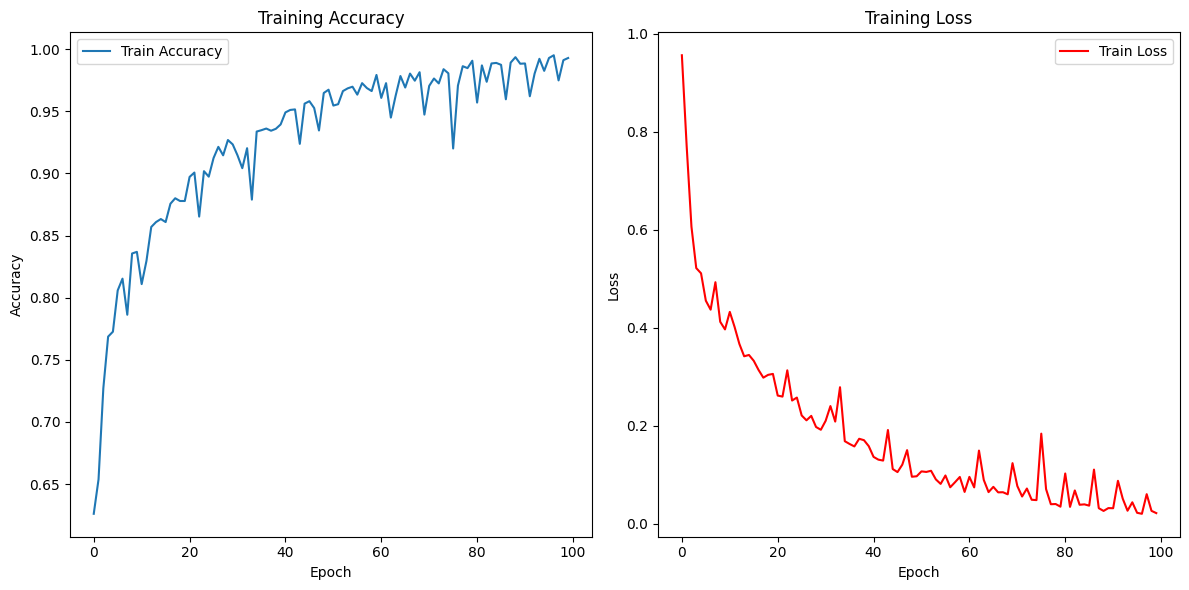

In [13]:
import matplotlib.pyplot as plt

# Membuat grafik untuk akurasi training
plt.figure(figsize=(12, 6))

# Plot akurasi training
plt.subplot(1, 2, 1)
plt.plot(train_log, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

# Plot loss training
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Menyimpan gambar
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [14]:
import pickle

def save_model_to_pickle(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Save the trained model
save_model_to_pickle(CNN, 'trained_model_manual_10000002_32_7_resize64_arsitekturbaru.pkl')

In [15]:
def load_model_from_pickle(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

# Load the model
CNN_loaded = load_model_from_pickle('trained_model_manual_10000002_32_7_resize64_arsitekturbaru.pkl')

In [16]:
# Hitung prediksi dan loss untuk data uji
predicted_test, test_loss = predict(CNN_loaded, X_TEST, Y_TEST, 0)

# Hitung akurasi
accuracy = np.mean(predicted_test == np.array(Y_TEST))

print("ACCR = %f" % accuracy)

ACCR = 0.964789


Precision: 0.9647887323943662
Recall: 0.9647887323943662
F1 Score: 0.9647887323943662


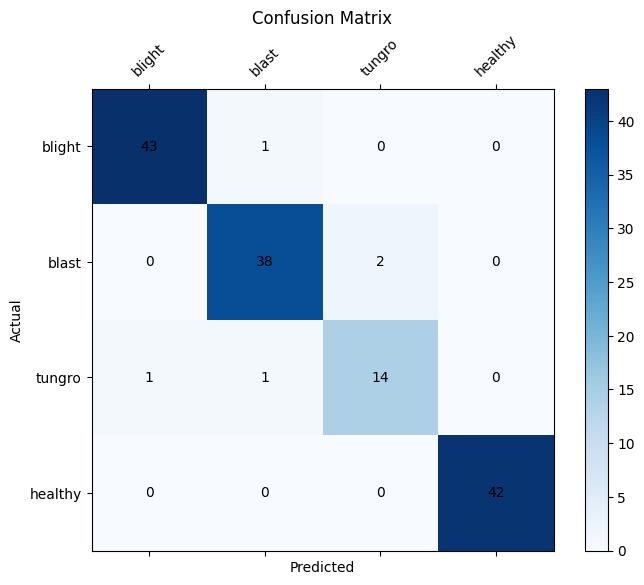

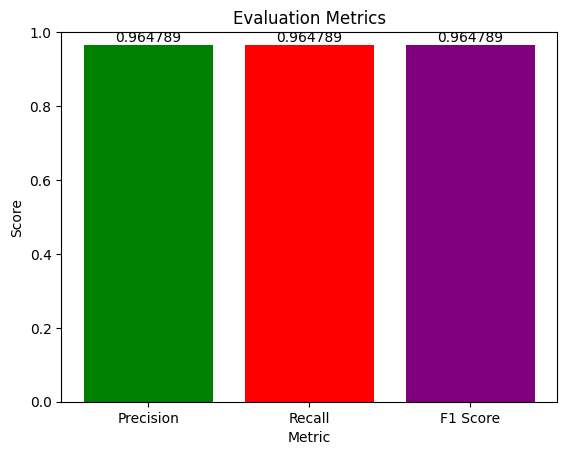

In [17]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Nama kelas
class_names = ['blight', 'blast', 'tungro', 'healthy']

# 1. Hitung confusion matrix
cm = confusion_matrix(Y_TEST, predicted_test, labels=[0, 1, 2, 3])

# 2. Hitung precision, recall, dan f1-score per kelas
precision = precision_score(Y_TEST, predicted_test, average='weighted')
recall = recall_score(Y_TEST, predicted_test, average='weighted')
f1 = f1_score(Y_TEST, predicted_test, average='weighted')

# Cetak metrik
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# 3. Visualisasi confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='Blues')  # Menampilkan confusion matrix dengan colormap 'Blues'
fig.colorbar(cax)  # Menambahkan color bar

# Menambahkan teks nilai ke dalam confusion matrix
for (i, j), value in np.ndenumerate(cm):
    ax.text(j, i, f'{value}', ha='center', va='center', color='black')

ax.set_xlabel('Predicted')  # Label sumbu x
ax.set_ylabel('Actual')  # Label sumbu y
ax.set_title('Confusion Matrix')  # Judul
ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticks(np.arange(len(class_names)))
ax.set_yticklabels(class_names)
plt.show()

# 4. Visualisasi metrik evaluasi
metrics = [precision, recall, f1]
metric_names = ['Precision', 'Recall', 'F1 Score']

fig, ax = plt.subplots()
bars = ax.bar(metric_names, metrics, color=['green', 'red', 'purple'])

# Tambahkan nilai di atas setiap batang dengan enam angka di belakang koma
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.6f}', ha='center', va='bottom')

ax.set_xlabel('Metric')  # Label sumbu x
ax.set_ylabel('Score')  # Label sumbu y
ax.set_title('Evaluation Metrics')  # Judul
ax.set_ylim(0, 1)  # Rentang sumbu y
plt.show()